# Brownian with disk & particles

no interaction between particles

In [1]:
import numpy as np
import matplotlib as plt


# Particles constant parameters 
m = 1  # Mass (units of m0).

# Disk constant parameters
disk_mass = 10
disk_radius = 10 # radius of disk

# Parameters for the simulation.
N_particles = 625  # Number of particles.
sigma = 1  # Size (units of sigma0).
epsilon = 1  # Energy (unit of epsilon0).

dt = 0.005   # Time step (units of t0 = sigma * sqrt(m0 /(2 * epsilon0))).
T_total = 400
num_steps = T_total / dt

L = 260  # Box size 
x_min, x_max, y_min, y_max = -L/2, L/2, -L/2, L/2

# neighbours for disk
cutoff_radius = 3 * disk_radius  # Cutoff_radius for neighbours list.


In [2]:

def list_neighbours(x, y, disk_x, disk_y, N_particles, cutoff_radius):
    '''Prepare a neigbours list for disk'''
    neighbours = []
    neighbour_number = 0  # 用于计数邻居的数量
    
    for j in range(N_particles):
        distance = np.sqrt((disk_x - x[j]) ** 2 + (disk_y - y[j]) ** 2)
    
        if distance <= cutoff_radius:
            neighbours.append(j)  
            neighbour_number += 1

    return neighbours, neighbour_number



## Define the Lennard-Jones potential

Only happens between particles and disk.

In [3]:
def single_force_cutoff(x_particle, y_particle, disk_x, disk_y, sigma, epsilon, disk_radius):
    '''
    Calculate the force on the disk due to a single particle using the Lennard-Jones potential.
    
    Parameters:
    - x_particle, y_particle: one of the neighbor particle position
    - disk_x, disk_y:  disk position 
    - sigma: Size parameter for Lennard-Jones potential.
    - epsilon: Energy parameter for Lennard-Jones potential.
    
    Returns:
    - Fx, Fy: Force on the disk.
    '''
    
  
    r2 = (disk_x - x_particle) ** 2 + (disk_y - y_particle) ** 2 
    r = np.sqrt(r2) -  disk_radius  # Distance 

    ka = sigma / r
    F = 24 * epsilon / r * (2 * (ka**12) - (ka** 6))  # force magenitute
    
    Fx = F * (disk_x - x_particle) / np.sqrt(r2) # force vector :  particle to disk 
    Fy = F * (disk_y - y_particle) / np.sqrt(r2)

    return Fx, Fy 


## Main loop 

- use half time step udpdate particles and disk velocity and position 
- Initially, the particles are positioned on a squared lattice. They have a velocity with random orientation and magnitude v.
The disk start from the center of the box from rest (i.e., its velocity is 0).

/var/folders/kn/b6dxkrhj663373b1qhlgyyg40000gn/T/ipykernel_3081/2929326026.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


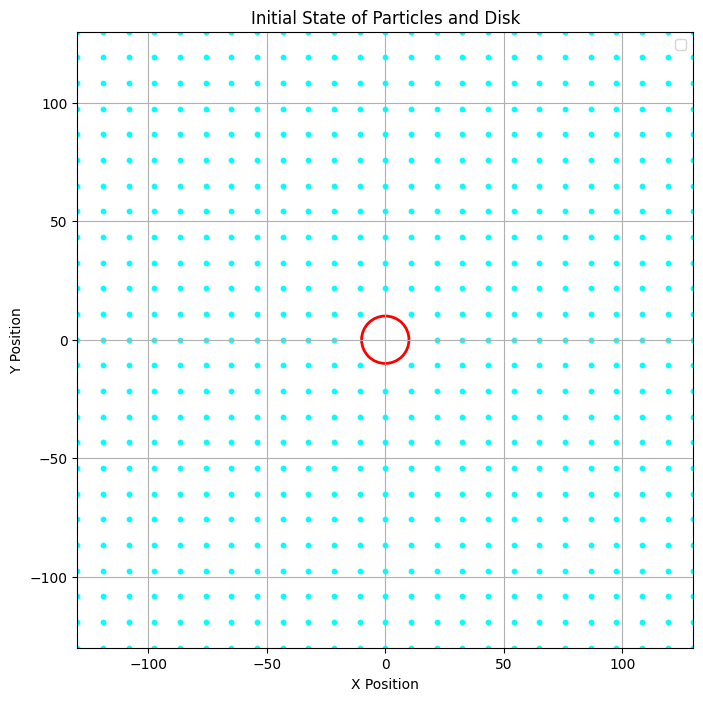

'4467194752stop_loop'

In [4]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *
import math 
import matplotlib.pyplot as plt

# Visualization 

v0 = 10  # Initial speed 
x0, y0 = np.meshgrid(
    np.linspace(- L / 2, L / 2, int(np.sqrt(N_particles))),
    np.linspace(- L / 2, L / 2, int(np.sqrt(N_particles))),
)
x0 = x0.flatten()[:N_particles]
y0 = y0.flatten()[:N_particles]
phi0 = (2 * np.random.rand(N_particles) - 1) * np.pi


filtered_indices = []

for i in range(N_particles):
    distance_to_center = np.sqrt((x0[i] - 0) ** 2 + (y0[i] - 0) ** 2)
    if distance_to_center > disk_radius + 3 * sigma:
        filtered_indices.append(i)

# Filter the particle positions and angles
x0 = x0[filtered_indices]
y0 = y0[filtered_indices]
phi0 = phi0[filtered_indices]
N_particles = len(filtered_indices)  # Update the number of particles


# Preperation for particle update
x = x0
y = y0
v = np.full(N_particles, v0) # save all particles velocity 
phi = phi0
vx = v0 * np.cos(phi0)
vy = v0 * np.sin(phi0)

disk_x= 0
disk_y = 0

disk_phi = 0
disk_v = 0
disk_vx = disk_v * np.cos(disk_phi)
disk_vy = disk_v * np.sin(disk_phi)


disk_positions = []
disk_velocities = []
disk_positions.append([disk_x, disk_y])
#disk_velocities.append([disk_vx, disk_vy])
#disk_phi.append(disk_phi)


# Plot the initial state
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Plot particles
ax.scatter(x, y, color='cyan', s=10)

# Plot disk as a circle
disk_circle = plt.Circle((disk_x, disk_y), disk_radius, color='red', fill=False, linewidth=2)
ax.add_patch(disk_circle)

# Adding labels and title
ax.set_title("Initial State of Particles and Disk")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend()

# Show plot
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.show()


window_size = 600

tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window 
tk.attributes('-topmost', 0)
canvas.place(x=10, y=10, height=window_size, width=window_size)


neighbor_particles = [] # save neighbor particles elements

particles = []
for j in range(1, N_particles):
    particles.append(
        canvas.create_oval(
            (x[j] - sigma / 2) / L * window_size + window_size / 2, 
            (y[j] - sigma / 2) / L * window_size + window_size / 2,
            (x[j] + sigma / 2) / L * window_size + window_size / 2, 
            (y[j] + sigma / 2) / L * window_size + window_size / 2,
            outline='#00C0C0', 
            fill='#00C0C0',
        )
    )


disk_element = canvas.create_oval(
    (disk_x - disk_radius) / L * window_size + window_size / 2,
    (disk_y - disk_radius) / L * window_size + window_size / 2,
    (disk_x + disk_radius) / L * window_size + window_size / 2,
    (disk_y + disk_radius) / L * window_size + window_size / 2,
    outline='#FF0000', 
    fill='',  # 可使用透明填充或特定颜色
)

step = 0

def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.


In [5]:
# Define boundary condition  for particle 
def boundary_condition_particle(x, y, vx, vy , x_min, x_max, y_min, y_max):
    if x < x_min:
            x = x_min + (x_min - x)
            vx = - vx

    if x > x_max:
        x = x_max - (x - x_max)
        vx = - vx

    if y < y_min:
        y = y_min + (y_min - y)
        vy = - vy
            
    if y > y_max:
        y = y_max - (y - y_max)
        vy = - vy
    return x, y, vx, vy 
# Define boundary condition for disk (consider the radius)
def boundary_condition_disk(disk_radius, disk_x, disk_y, disk_vx, disk_vy , x_min, x_max, y_min, y_max):
    if disk_x - x_min <= disk_radius:
        disk_x = x_min + (x_min - disk_x)
        disk_vx = - disk_vx

    if x_max - disk_x <= disk_radius :
        disk_x = x_max - (disk_x - x_max)
        disk_vx = - disk_vx

    if disk_y - y_min <=  disk_radius:
        disk_y = y_min + (y_min - disk_y)
        disk_vy = - disk_vy
            
    if y_max - disk_y <= disk_radius:
        disk_y = y_max - (disk_y - y_max)
        disk_vy = - disk_vy

    return disk_x, disk_y, disk_vx, disk_vy 

In [6]:

# Main loop

running = True  # Flag to control the loop.

while running:
    neighbours, neighbour_number = list_neighbours( x, y, disk_x, disk_y, N_particles, cutoff_radius)
    total_force = np.array([0.0, 0.0])


    half_disk_x = disk_x + disk_vx * dt * 0.5
    half_disk_y = disk_y + disk_vy * dt * 0.5

    for i in range(neighbour_number):
        particle_index = neighbours[i]
        
        half_x = x[particle_index] + vx[particle_index] * dt * 0.5
        half_y = y[particle_index] + vy[particle_index] * dt * 0.5 

        fx, fy = single_force_cutoff(x[particle_index], y[particle_index], disk_x, disk_y, sigma, epsilon, disk_radius)
        total_force[0] += fx  # Fx : total force on disk
        total_force[1] += fy  # Fy: total force on disk

        nvx = vx[particle_index] - fx / m * dt # N2 law, -fx = force on particle 
        nvy = vy[particle_index] - fy / m * dt # N2 law, -fy = force on particle 


        nx = half_x + 0.5 * nvx * dt
        ny = half_y + 0.5 * nvy * dt  
        nv = np.sqrt(nvx ** 2 + nvy ** 2)
        nphi = math.atan2(nvy, nvx)
        
        nx, nx , nvx, nvy = boundary_condition_particle(nx, ny, nvx, nvy, x_min, x_max, y_min, y_max)

        x[particle_index] = nx
        y[particle_index] = ny
        phi[particle_index] = nphi
        v[particle_index] = nv
        vx[particle_index] = nvx
        vy[particle_index] = nvy

        #print(f'Step time  = {step}, nei. num = {neighbour_number}, nei.index = {i}, total force = {total_force} ')
       #print(f'Particle position= [ {x[particle_index]}, {y[particle_index]}] ')

    next_disk_vx = disk_vx + total_force[0] / disk_mass  * dt
    next_disk_vy = disk_vy + total_force[1] / disk_mass  * dt

    next_disk_x = half_disk_x + next_disk_vx * dt * 0.5
    next_disk_y = half_disk_y + next_disk_vy * dt * 0.5

    next_disk_v = np.sqrt(next_disk_vx **2  + next_disk_vy **2)
    next_disk_phi = math.atan2(next_disk_vy, next_disk_vx)

    next_disk_x, next_disk_y, next_disk_vx, next_disk_vy = boundary_condition_disk(disk_radius, next_disk_x, next_disk_y, next_disk_vx, next_disk_vy, x_min, x_max, y_min, y_max )

    disk_x = next_disk_x
    disk_y = next_disk_y
    disk_vx = next_disk_vx
    disk_vy = next_disk_vy
    disk_v = next_disk_v
    disk_phi = next_disk_phi

    print(f'Steps = {step}, total force on disk ={total_force}, disk position = [{disk_x}, {disk_y}]')

    disk_positions.append([disk_x, disk_y])
    
    
    #disk_velocities.append([disk_vx, disk_vy])

    # update particle that not in neighbors
    for j in range(N_particles):
        if j not in neighbours:
            x[j] += vx[j] * dt
            y[j] += vy[j] * dt
            x[j], y[j], vx[j], vy[j] = boundary_condition_particle(x[j], y[j], vx[j], vy[j], x_min, x_max, y_min, y_max)

    # # Update neighbors
    # neighbours, neighbour_number = list_neighbours(x, y, disk_x, disk_y, N_particles, cutoff_radius)
    
    # # clear previous neighbor elements
    # for neighbor_particle in neighbor_particles:
    #     canvas.delete(neighbor_particle)
    #     neighbor_particles.clear()

    # # Draw new neighbors
    # for particle_index in neighbours:
    #     neighbor_particles.append(
    #         canvas.create_oval(
    #             (x[particle_index] - sigma / 2) / L * window_size + window_size / 2,
    #             (y[particle_index] - sigma / 2) / L * window_size + window_size / 2,
    #             (x[particle_index] + sigma / 2) / L * window_size + window_size / 2,
    #             (y[particle_index] + sigma / 2) / L * window_size + window_size / 2,
    #             outline='#FF00FF',  
    #              fill='#FF00FF',
    #         )
    #     )


 
    # Update animation frame.
    if step % 100 == 0:        
        # canvas.coords(
        #     specialparticle,
        #     (x[0] - sigma / 2) / L * window_size + window_size / 2,
        #     (y[0] - sigma / 2) / L * window_size + window_size / 2,
        #     (x[0] + sigma / 2) / L * window_size + window_size / 2,
        #     (y[0] + sigma / 2) / L * window_size + window_size / 2,
        # )
        for j, particle in enumerate(particles):
            canvas.coords(
                particle,
                (x[j + 1] - sigma / 2) / L * window_size + window_size / 2,
                (y[j + 1] - sigma / 2) / L * window_size + window_size / 2,
                (x[j + 1] + sigma / 2) / L * window_size + window_size / 2,
                (y[j + 1] + sigma / 2) / L * window_size + window_size / 2,
            )
            # Update disk visualization (assuming there is a disk element created)
            canvas.coords(
                disk_element,
                (disk_x - disk_radius) / L * window_size + window_size / 2,
                (disk_y - disk_radius) / L * window_size + window_size / 2,
                (disk_x + disk_radius) / L * window_size + window_size / 2,
                (disk_y + disk_radius) / L * window_size + window_size / 2,
        )
                    
        tk.title(f'Time {step * dt:.1f} - Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(.001)  # Increase to slow down the simulation.    

    step += 1


    if step >= num_steps:
        running = False
        tk.destroy() 
    


tk.update_idletasks()
tk.update()
tk.mainloop()


Steps = 0, total force on disk =[-3.40427835e-18 -3.36396488e-18], disk position = [-4.2553479432177964e-24, -4.204956100301066e-24]
Steps = 1, total force on disk =[-1.01275663e-05 -1.01275663e-05], disk position = [-1.2659457820295418e-11, -1.2659457820295264e-11]
Steps = 2, total force on disk =[-2.54269904e-05 -2.54269904e-05], disk position = [-6.976211150288914e-11, -6.976211150288887e-11]
Steps = 3, total force on disk =[-4.26718966e-05 -4.26718966e-05], disk position = [-2.119883739402466e-10, -2.1198837394024624e-10]
Steps = 4, total force on disk =[-6.20637546e-05 -6.20637546e-05], disk position = [-4.851342003102994e-10, -4.851342003102989e-10]
Steps = 5, total force on disk =[-8.3842158e-05 -8.3842158e-05], disk position = [-9.406624174216035e-10, -9.40662417421603e-10]
Steps = 6, total force on disk =[-0.00010829 -0.00010829], disk position = [-1.6363559909784869e-09, -1.6363559909784863e-09]
Steps = 7, total force on disk =[-0.00013574 -0.00013574], disk position = [-2.63

OverflowError: Python int too large to convert to C long

# Plot Trajectory of disk

In [1]:
disk_positions = np.array(disk_positions)

x_positions = disk_positions[:, 0]
y_positions = disk_positions[:, 1]


plt.figure(figsize=(10, 6))
plt.plot(x_positions, y_positions, label="Disk Position Trajectory", color='blue', linestyle='-', marker='o', markersize=2)


plt.title("Disk Position Trajectory Over Time")
plt.xlabel("X Position")
plt.ylabel("Y Position")

plt.grid(True)
plt.legend()

# 显示图
plt.show()

NameError: name 'np' is not defined